Import Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    f1_score
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


Load Dataset & Define Target

In [63]:
df = pd.read_csv("loan_prediction.csv")
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Separate Features & Target

In [64]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"].map({"Y": 1, "N": 0})  # Binary encoding


Data Preprocessing

In [65]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Impute numerical features using median
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Impute categorical features using mode
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Verify no missing values remain
X.isnull().sum().sum()


np.int64(0)

Train/Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train class distribution:")
print(y_train.value_counts(normalize=True))


Train class distribution:
Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64


Preprocessing Pipeline

In [67]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", pd.get_dummies)
])


Encode Categoricals

In [68]:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Baseline Models

In [69]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True)
}


Train & Evaluate Models

In [70]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

    print(f"\n{name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
[[22 16]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123


Decision Tree
[[22 16]
 [ 8 77]]
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.83      0.91      0.87        85

    accuracy                           0.80       123
   macro avg       0.78      0.74      0.76       123
weighted avg       0.80      0.80      0.80       123


SVM
[[ 0 38]
 [ 0 85]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.69      1.00      0.82        85

    accuracy                           0.69       123
   macro avg       0.35      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,F1 Score,ROC AUC
0,Logistic Regression,0.908108,0.851393
1,Decision Tree,0.865169,0.742415
2,SVM,0.817308,0.416409


Handle Imbalance: Class Weights

In [71]:
lr_balanced = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

lr_balanced.fit(X_train, y_train)
y_pred_bal = lr_balanced.predict(X_test)

print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))


[[26 12]
 [ 7 78]]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        38
           1       0.87      0.92      0.89        85

    accuracy                           0.85       123
   macro avg       0.83      0.80      0.81       123
weighted avg       0.84      0.85      0.84       123



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Handle Imbalance: SMOTE

In [72]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_sm, y_train_sm)

y_pred_sm = lr_smote.predict(X_test)

print(confusion_matrix(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm))


[[22 16]
 [ 2 83]]
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        38
           1       0.84      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.88      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Hyperparameter Tuning (GridSearchCV)

In [73]:
param_grid = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_grid,
    scoring="f1",
    cv=5
)

grid.fit(X_train, y_train)

grid.best_params_


{'max_depth': 5, 'min_samples_split': 5}

Best Model Evaluation

In [74]:
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_prob_best))


[[22 16]
 [11 74]]
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        38
           1       0.82      0.87      0.85        85

    accuracy                           0.78       123
   macro avg       0.74      0.72      0.73       123
weighted avg       0.77      0.78      0.78       123

ROC AUC: 0.7433436532507741


ROC Curve

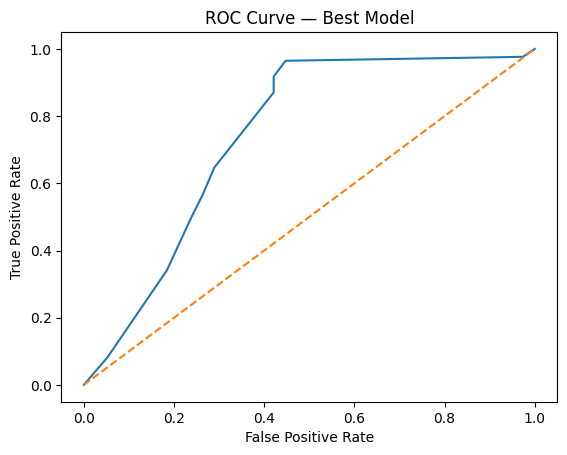

In [75]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Best Model")
plt.show()
